In [1]:
import numpy as np
import pandas as pd
import torchvision.transforms as transforms
import torch

import matplotlib.pyplot as plt

from medmnist import dataset
from medmnist import INFO

from collections import defaultdict

from pprint import pprint

In [2]:
# Define params for the NN training
n_epochs = 10
batch_size = 32
lr_g = 0.0002
lr_d = 0.0007
b1 = 0.5
b2 = 0.999
n_cpu = -1
latent_dim = 128
n_classes = 11
img_size = 28
channels = 1
sample_interval = 400

In [3]:
train_dataset = dataset.OrganAMNIST(
        split='train',
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
            transforms.Resize(img_size),
        ]),
        target_transform=transforms.Lambda(lambda x: x[0]),
        # flag=dataset_name,
        download=True
    )

len_train_data = train_dataset.imgs.shape[0]
train_dataset_imgs = np.zeros((len_train_data, 28, 28))
train_dataset_labels = np.zeros((len_train_data, 1))

for i, item in enumerate(train_dataset):
    train_dataset_imgs[i] = item[0]
    train_dataset_labels[i] = item[1]

Using downloaded and verified file: /home/rh/.medmnist/organamnist.npz


/home/rh/Uni/DLAM/.venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [4]:
generated = np.load("GAN-experiments/generated_organamnist_3.npz")

In [5]:
def get_statistics(data, labels):
    stats = defaultdict(lambda: {
        "#":0,
        "mean":0,
        "std":0,
        "min":0,
        "max":0
        })
    for n, (i, c) in enumerate(zip(data, labels)):
        stats[int(c.item())]["#"] +=1
        stats[int(c.item())]["mean"] += i.mean()
        stats[int(c.item())]["std"] += i.std()
        stats[int(c.item())]["min"] += i.min()
        stats[int(c.item())]["max"] += i.max()
    
    for c in stats.keys():
        num = stats[c]["#"]
        stats[c]["mean"] /= num
        stats[c]["std"] /= num
        stats[c]["min"] /= num
        stats[c]["max"] /= num
    
    df = pd.DataFrame(stats)
    df = df.reindex(sorted(df.columns), axis=1)
    # pprint(stats)

    return df



In [92]:
original_stats = get_statistics(((train_dataset_imgs+1)/2)*255, train_dataset_labels)
fake_stats = get_statistics(((generated["train_images"]+1)/2)*255, generated["train_labels"])

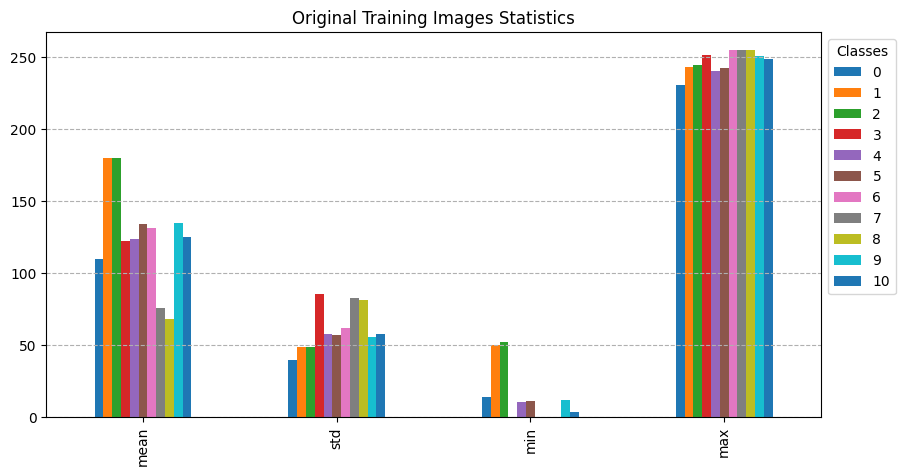

In [93]:
fig, ax = plt.subplots()
original_stats[original_stats.axes[0]!="#"].plot(kind="bar", title="Original Training Images Statistics", figsize=(10, 5), ax=ax)
ax.legend(title="Classes", bbox_to_anchor=(1,1))
ax.grid(axis='y', linestyle="dashed")
plt.show()

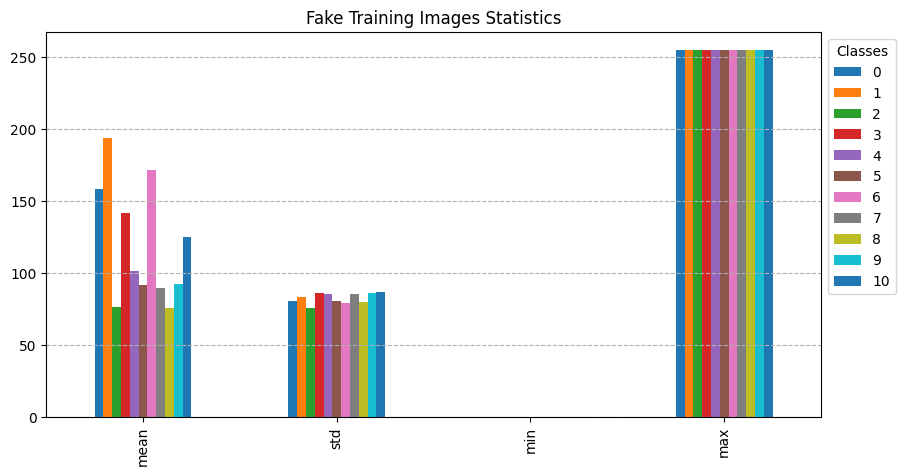

In [94]:
fig, ax = plt.subplots()
fake_stats[fake_stats.axes[0]!="#"].plot(kind="bar", title="Fake Training Images Statistics", figsize=(10, 5), ax=ax)
ax.legend(title="Classes", bbox_to_anchor=(1,1))
ax.grid(axis='y', linestyle="dashed")
plt.show()

In [81]:
def get_distribution(data, labels):
    stats = defaultdict(lambda: {
        "#":0,
        "bins": np.zeros((256,), dtype=float)
        })
    
    for n, (i, c) in enumerate(zip(data, labels)):
        stats[int(c.item())]["#"] +=1

        bins =np.rint(((i.flatten()+1)/2)*255).astype(int)
        # pprint(bins)
        stats[int(c.item())]["bins"] += np.bincount(bins, minlength=256)


    
    for c in stats.keys():
        num = stats[c]["#"]
        stats[c]["bins"] /= num
        # stats[c]["bins"][0] = 0
        # stats[c]["bins"][-1] = 0

    
    df = pd.DataFrame(stats)
    df = df.reindex(sorted(df.columns), axis=1)
    # pprint(stats)

    return df

In [82]:
original_bins = get_distribution(train_dataset_imgs, train_dataset_labels)
fake_bins = get_distribution(generated["train_images"], generated["train_labels"])

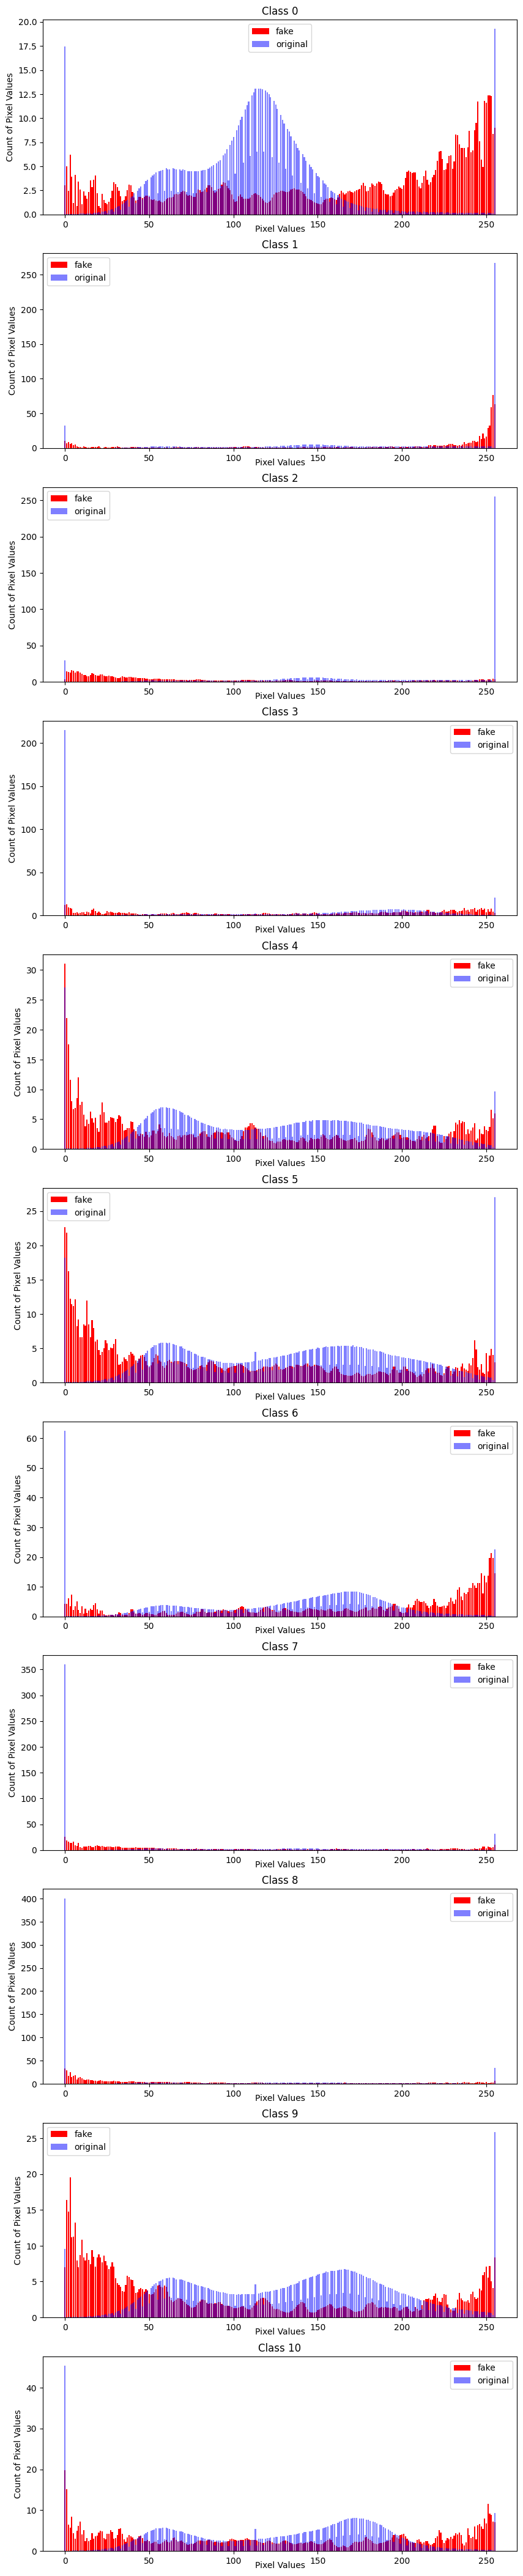

In [91]:
fig, ax = plt.subplots(nrows=11,figsize=(10, 30))
fig.subplots_adjust(bottom=-0.5,)
for i in range(11):
    ax[i].set_title(f"Class {i}")
    ax[i].set_xlabel(f"Pixel Values", labelpad=-5)
    ax[i].set_ylabel(f"Count of Pixel Values")
    ax[i].bar(x=range(0,256) ,height=fake_bins[i].bins, label="fake", alpha=1, color="red")
    ax[i].bar(x=range(0,256) ,height=original_bins[i].bins, label="original", alpha=0.5, color="blue")
    ax[i].legend()

# fig.legend()